In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from TVL2 import *
from TVICE import *
import warnings 
warnings.filterwarnings('ignore')

# TV - Iterated Conditional Expectation

Ce notebook porte sur le débruitage d'images grâce à l'algorithme *Iterated Conditional Expectation*. Il est inspiré de l'article

[Louchet, C.,  Moisan, L., *Total variation denoising using iterated conditional expectation*. In 2014 22nd European Signal Processing Conference (EUSIPCO) (pp. 1592-1596). 2014](https://hal.archives-ouvertes.fr/hal-01214735)

Voir le sujet PDF associé pour plus de détails.

## Question 1

\begin{align}
\pi(u(i)|u(i^c)) &= p(u(i)|u(i^c),u_0(i)) \\
&\propto p(u(i),u(i^c),u_0(i)) = p(u_0(i)|u(i^c)) p(u(i),u(i^c)) \\
&\propto p(u_0(i)|u(i^c)) p(u(i)|u(i^c)) = e^{\frac{1}{2\sigma^2}|u(i)-u_0(i)|^2} e^{-\lambda \sum_{j\in \mathcal{N}(i)} |u(j)-u(i)|}
\end{align}


## Question 2

$$ \pi(u(i)|u(i^c)=w(i^c)) = \frac{1}{Z} e^{\frac{1}{2\sigma^2}|u(i)-u_0(i)|^2} e^{-\lambda \sum_{j\in \mathcal{N}(i)} |u(j)-u(i)|}$$


$$ 1 = \int_\mathbb{R} \pi(u(i)|u(i^c)=w(i^c)) \mathrm{d}u(i) = \frac{1}{Z} \int_\mathbb{R} e^{\frac{1}{2\sigma^2}|u(i)-u_0(i)|^2} e^{-\lambda \sum_{j\in \mathcal{N}(i)} |u(j)-u(i)|} \mathrm{d}u(i)$$

Donc $Z = \int_\mathbb{R} e^{\frac{1}{2\sigma^2}|u(i)-u_0(i)|^2} e^{-\lambda \sum_{j\in \mathcal{N}(i)} |u(j)-u(i)|} \mathrm{d}u(i)$

\begin{align}
\mathbb{E}_{U \sim \pi}\left[U(i)|U(i^c)=w(i^c)\right]\ & = \int_\mathbb{R} u(i) \pi(u(i)|u(i^c)=w(i^c))\mathrm{d}u(i) \\
& = \frac{1}{Z} \int_\mathbb{R} u(i) e^{\frac{1}{2\sigma^2}|u(i)-u_0(i)|^2} e^{-\lambda \sum_{j\in \mathcal{N}(i)} |w(j)-u(i)|} \mathrm{d}u(i) \\
& = \frac{1}{Z} \int_\mathbb{R} (u_0(i)+s) e^{\frac{1}{2\sigma^2}s^2} e^{-\lambda \sum_{j\in \mathcal{N}(i)} |u(j)-(u_0(i)+s)|} \mathrm{d}u(i) \\
& = \frac{u_0(i)}{Z} \int_\mathbb{R} e^{\frac{1}{2\sigma^2}s^2} e^{-\lambda \sum_{j\in \mathcal{N}(i)} |u_0(i)+s-w(j)|} \mathrm{d}u(i) + \frac{1}{Z} \int_\mathbb{R} s e^{\frac{1}{2\sigma^2}s^2} e^{-\lambda \sum_{j\in \mathcal{N}(i)} |u_0(i)+s-w(j)|} \mathrm{d}u(i) \\
& = u_0(i) + \frac{1}{Z} \int_\mathbb{R} s e^{\frac{1}{2\sigma^2}s^2} e^{-\lambda \sum_{j\in \mathcal{N}(i)} |u_0(i)+s-w(j)|} \mathrm{d}u(i) \\
\end{align}

## Question 3
A cause de l'exponentielle, certaines valeurs de $X_k$ pourraient exploser,
ce qui conduirait à un dépassement de mémoire. Le logarithme permet d'éviter cela, et en enlevant $M$, on s'assure d'avoir des valeurs de $X_k'$ comprises entre 0 et 1, donc bornées.

In [2]:
x0 = 1e-10
x1 = 1e-10
x2 = 1e-10
x_1 = 1e-10
x_2 = 1e-10
# Alors le calcul du quotient devrait donner 0
print((2*x_2 + x_1 - x1 - 2*x2) / (x_2 + x_1 + x0 + x1 + x2))

-5.1698788284564224e-17


Alors le calcul du quotient devrait donner $0$, mais ce n'est pas ce que l'on obtient.

In [3]:
L0 = np.log(x0)
L1 = np.log(x1)
L2 = np.log(x2)
L_1 = np.log(x_1)
L_2 = np.log(x_2)
M = np.max([L0,L1,L2,L_1,L_2])
x0 = np.exp(L0-M)
x1 = np.exp(L1-M)
x2 = np.exp(L2-M)
x_1 = np.exp(L_1-M)
x_2 = np.exp(L_2-M)
print((2*x_2 + x_1 - x1 - 2*x2) / (x_2 + x_1 + x0 + x1 + x2))

0.0


Avec cette méthode de calcul, on obtient la valeur attendue.

## Question 4

In [4]:
lambd = 20     # TV regularization parameter 
sig = 0.05  # noise standard deviation

In [5]:
def tvice(u0,sig,lambd,niter): 
# usage: out = tvice(u0,sigma,lambda,niter) 
# TV-ICE denoising algorithm (vectorized version)
    u = np.copy(u0)
    (nx,ny) = u.shape
    for k in range(niter):
        V = np.zeros((4,nx,ny))
        V[0,1::] = u[0:-1]
        V[1,0:-1] = u[1::]
        V[2,:,1::] = u[:,0:-1]
        V[3,:,0:-1] = u[:,1::]
        V = np.sort(V,axis=0)
        a = V[0]
        b = V[1]
        c = V[2]
        d = V[3]
        logX_2 = logerfc((u0-a+4*lambd*sig**2)/(np.sqrt(2)*sig)) + 2*lambd*(2*(u0+2*lambd*sig**2)-a-b)
        logX_1 = logerf2((a-u0-2*lambd*sig**2)/(np.sqrt(2)*sig),(b-u0-2*lambd*sig**2)/(np.sqrt(2)*sig)) + lambd*(2*(u0-b)+2*lambd*sig**2)
        logX0 = logerf2((b-u0)/(np.sqrt(2)*sig),(c-u0)/(np.sqrt(2)*sig))
        logX1 = logerf2((c-u0+2*lambd*sig**2)/(np.sqrt(2)*sig),(d-u0+2*lambd*sig**2)/(np.sqrt(2)*sig)) + lambd*(2*(c-u0)+2*lambd*sig**2)
        logX2 = logerfc((d-u0+4*lambd*sig**2)/(np.sqrt(2)*sig)) + 2*lambd*(c+d-2*(u0-2*lambd*sig**2))
        LOG = np.array([logX_2,logX_1,logX0,logX1,logX2])
        M = np.max(LOG,axis=0)
        x_2 = np.exp(logX_2-M)
        x_1 = np.exp(logX_1-M)
        x0 = np.exp(logX0-M)
        x1 = np.exp(logX1-M)
        x2 = np.exp(logX2-M)
        u_tilde = u0 + 2*lambd*sig**2*(2*x_2+x_1-x1-2*x2)/(x_2+x_1+x0+x1+x2)
        u = u_tilde
    return u

In [6]:
# image creation
n = 100    # start with small images for your experimentations
i = 100
u = plt.imread('./images/simpson512.png')
u = u[:,:,1]
u = u[i:i+n,i:i+n]
nr,nc = u.shape

# add noise
ub = u + sig*np.random.randn(nr,nc)
noise = np.random.rand(nr,nc)

## denoise ub using the TV-ICE scheme
out = tvice(ub,sig,lambd,100)

## Question 5

<Figure size 720x720 with 0 Axes>

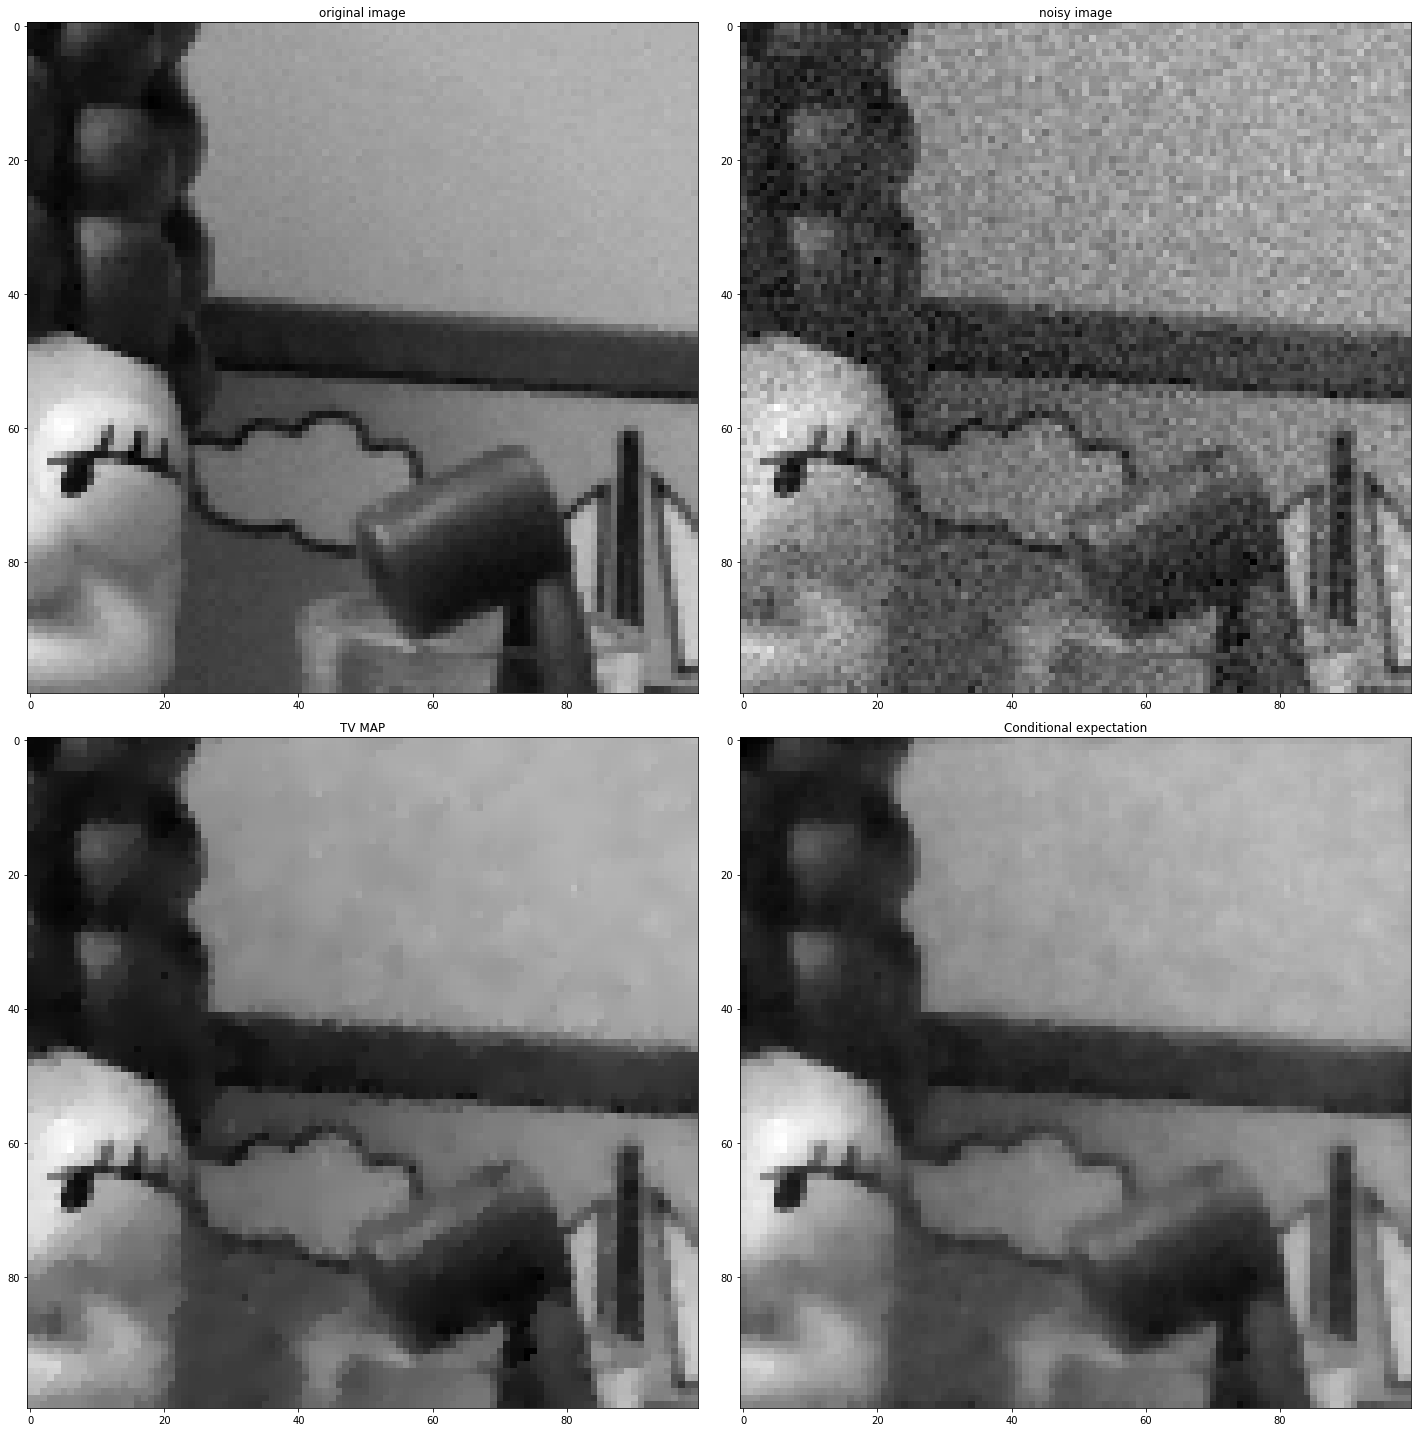

<Figure size 720x720 with 0 Axes>

In [7]:
# TV-MAP
u_tvmap = chambolle_pock_prox_TV1(ub,sig**2*lambd,100)

## display
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(20, 20))
axes[0,0].imshow(u,cmap='gray')
axes[0,0].set_title('original image')
axes[0,1].imshow(ub,cmap='gray')
axes[0,1].set_title('noisy image')
axes[1,0].imshow(u_tvmap,cmap='gray')
axes[1,0].set_title('TV MAP')
axes[1,1].imshow(out,cmap='gray')
axes[1,1].set_title('Conditional expectation')
fig.tight_layout()
plt.figure(figsize = (10,10))

Cette méthode donne un résultat très satisfaisant. L'image est correctement débruitée et plus régulière qu'avec le Maximum a posteriori.

## Question 6

In [8]:
U_inf = tvice(ub,sig,lambd,1000)

In [9]:
D = []
niter = 100
U = np.copy(ub)
(nx,ny) = U.shape
for k in range(niter):
    V = np.zeros((4,nx,ny))
    V[0,1::] = U[0:-1]
    V[1,0:-1] = U[1::]
    V[2,:,1::] = U[:,0:-1]
    V[3,:,0:-1] = U[:,1::]
    V = np.sort(V,axis=0)
    a = V[0]
    b = V[1]
    c = V[2]
    d = V[3]
    logX_2 = logerfc((ub-a+4*lambd*sig**2)/(np.sqrt(2)*sig)) + 2*lambd*(2*(ub+2*lambd*sig**2)-a-b)
    logX_1 = logerf2((a-ub-2*lambd*sig**2)/(np.sqrt(2)*sig),(b-ub-2*lambd*sig**2)/(np.sqrt(2)*sig)) + lambd*(2*(ub-b)+2*lambd*sig**2)
    logX0 = logerf2((b-ub)/(np.sqrt(2)*sig),(c-ub)/(np.sqrt(2)*sig))
    logX1 = logerf2((c-ub+2*lambd*sig**2)/(np.sqrt(2)*sig),(d-ub+2*lambd*sig**2)/(np.sqrt(2)*sig)) + lambd*(2*(c-ub)+2*lambd*sig**2)
    logX2 = logerfc((d-ub+4*lambd*sig**2)/(np.sqrt(2)*sig)) + 2*lambd*(c+d-2*(ub-2*lambd*sig**2))
    LOG = np.array([logX_2,logX_1,logX0,logX1,logX2])
    M = np.max(LOG,axis=0)
    x_2 = np.exp(logX_2-M)
    x_1 = np.exp(logX_1-M)
    x0 = np.exp(logX0-M)
    x1 = np.exp(logX1-M)
    x2 = np.exp(logX2-M)
    u_tilde = ub + 2*lambd*sig**2*(2*x_2+x_1-x1-2*x2)/(x_2+x_1+x0+x1+x2)
    U = u_tilde
    D.append(np.sqrt(np.sum((U-U_inf)**2)))
D = np.array(D)

$$\log||u^k-u^\infty|| = O(k\log(\alpha))$$

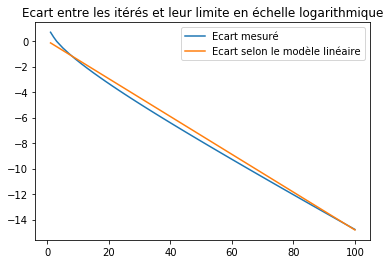

In [10]:
X = np.arange(1,niter+1)
plt.figure()
plt.title("Ecart entre les itérés et leur limite en échelle logarithmique")
plt.plot(X,np.log(D),label='Ecart mesuré')
P = np.polyfit(X,np.log(D),1)
alpha = np.exp(P[0])
plt.plot(X,np.log(alpha**X),label='Ecart selon le modèle linéaire')
plt.legend();

In [11]:
alpha

0.8623158366130967

la vitesse de convergence des itérées $u_k$ vers leur limite $u_\infty$ semble bien linéaire, avec $\alpha \simeq 0.86$